## Introduction to Vertex Pipelines


1 hour 30 minutes
Free



### Overview
In this lab, you learn how to create and run ML pipelines with Vertex Pipelines.

### Objectives
* Use the Kubeflow Pipelines SDK to build scalable ML pipelines.
* Create and run a 3-step intro pipeline that takes text input.


### Setup and requirements
For each lab, you get a new Google Cloud project and set of resources for a fixed time at no cost.

1. Sign in to Qwiklabs using an incognito window.

2. Note the lab's access time (for example, 1:15:00), and make sure you can finish within that time.
There is no pause feature. You can restart if needed, but you have to start at the beginning.

3. When ready, click Start lab.

4. Note your lab credentials (Username and Password). You will use them to sign in to the Google Cloud Console.

5. Click Open Google Console.

6. Click Use another account and copy/paste credentials for this lab into the prompts.
If you use other credentials, you'll receive errors or incur charges.

7. Accept the terms and skip the recovery resource page.

**Note:** Do not click End Lab unless you have finished the lab or want to restart it. This clears your work and removes the project.

## Start Cloud Shell
In this lab, you're going to work in a Cloud Shell session, which is a command interpreter hosted by a virtual machine running in Google's cloud. You could just as easily run this section locally on your own computer, but using Cloud Shell gives everyone access to a reproducible experience in a consistent environment. After the lab, you're welcome to retry this section on your own computer.

The first time you make a request in Cloud Shell requiring authorization, you will see an "Authorize Cloud Shell" dialog. You may safely click the Authorize button.

### Activate Cloud Shell
Cloud Shell is a virtual machine that contains development tools. It offers a persistent 5-GB home directory and runs on Google Cloud. Cloud Shell provides command-line access to your Google Cloud resources. gcloud is the command-line tool for Google Cloud. It comes pre-installed on Cloud Shell and supports tab completion.

1. Click the Activate Cloud Shell button (Activate Cloud Shell icon) at the top right of the console.

2. Click Continue.
It takes a few moments to provision and connect to the environment. When you are connected, you are also authenticated, and the project is set to your PROJECT_ID.

Sample commands
List the active account name:

`gcloud auth list`

(Output)
```
Credentialed accounts:
 - <myaccount>@<mydomain>.com (active)
```

(Example output)
```
Credentialed accounts:
 - google1623327_student@qwiklabs.net
```

List the project ID:
```
gcloud config list project
```

(Output)
```
[core]
project = <project_ID>
(Example output)
```

```
[core]
project = qwiklabs-gcp-44776a13dea667a6
```

Note: Full documentation of gcloud is available in the gcloud CLI overview guide.
Cloud Shell has a few environment variables, including GOOGLE_CLOUD_PROJECT which contains the name of our current Cloud project. We use this in various places throughout this lab. You can see it by running:

```
echo $GOOGLE_CLOUD_PROJECT
```

Enable APIs
In later steps, you see where these services are needed (and why), but for now, run this command to give your project access to the Compute Engine, Container Registry, and Vertex AI services:

```
gcloud services enable compute.googleapis.com         \
                       containerregistry.googleapis.com  \
                       aiplatform.googleapis.com  \
                       cloudbuild.googleapis.com \
                       cloudfunctions.googleapis.com

```

This should produce a successful message similar to this one:
```
Operation "operations/acf.cc11852d-40af-47ad-9d59-477a12847c9e" finished successfully.
```


## Introduction to Vertex AI
This lab uses the newest AI product offering available on Google Cloud. Vertex AI integrates the ML offerings across Google Cloud into a seamless development experience. Previously, models trained with AutoML and custom models were accessible via separate services. The new offering combines both into a single API, along with other new products. You can also migrate existing projects to Vertex AI.

In addition to model training and deployment services, Vertex AI also includes a variety of MLOps products, including Vertex Pipelines (the focus of this lab), Model Monitoring, Feature Store, and more. You can see all Vertex AI product offerings in the diagram below.

Vertex AI products diagram

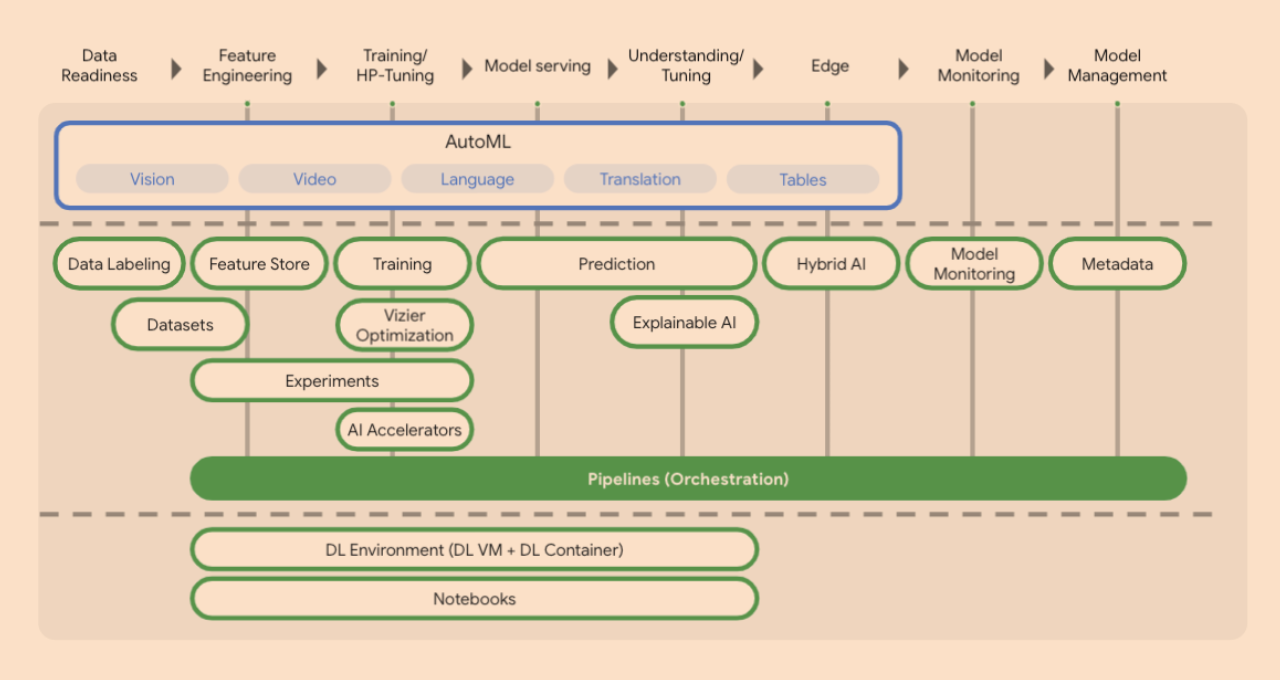

## Why are ML pipelines useful?
Before we dive in, let's first understand why you would want to use a pipeline. Imagine you're building out a ML workflow that includes processing data, training a model, hyperparameter tuning, evaluation, and model deployment. Each of these steps may have different dependencies, which may become unwieldy if you treat the entire workflow as a monolith.

As you begin to scale your ML process, you might want to share your ML workflow with others on your team so they can run it and contribute code. Without a reliable, reproducible process, this can become difficult. With pipelines, each step in your ML process is its own container. This lets you develop steps independently and track the input and output from each step in a reproducible way. You can also schedule or trigger runs of your pipeline based on other events in your Cloud environment, like kicking off a pipeline run when new training data is available.

# Task 1. Create a Cloud Storage bucket
To run a training job on Vertex AI, we need a storage bucket in which to store our saved model assets. The bucket needs to be regional. We're using US-central here, but you are welcome to use another region (just replace it throughout this lab).

If you already have a bucket you can skip this step.

1. Run the following commands in your Cloud Shell terminal to create a bucket:
```
BUCKET_NAME=gs://$GOOGLE_CLOUD_PROJECT-bucket
gsutil mb -l us-central1 $BUCKET_NAME
```


2. Next we give our compute service account access to this bucket. This ensures that Vertex Pipelines has the necessary permissions to write files to this bucket.

Run the following command to add this permission:
```
gcloud projects describe $GOOGLE_CLOUD_PROJECT > project-info.txt
PROJECT_NUM=$(cat project-info.txt | sed -nre 's:.*projectNumber\: (.*):\1:p')
SVC_ACCOUNT="${PROJECT_NUM//\'/}-compute@developer.gserviceaccount.com"
gcloud projects add-iam-policy-binding $GOOGLE_CLOUD_PROJECT --member serviceAccount:$SVC_ACCOUNT --role roles/storage.objectAdmin
```


## Task 2. Set up your environment
### Enable the Vertex AI API
1. In the Google Cloud Console, on the Navigation menu, click Vertex AI.
2. Click Enable Vertex AI API.

## Task 3. Launch a Vertex AI Notebooks instance
1. In the Google Cloud Console, on the Navigation Menu, click Vertex AI > Workbench. Select User-Managed Notebooks.

2. On the Notebook instances page, Click Create New and choose the latest version of TensorFlow Enterprise 2.6 (with LTS) in Environment.

3. In the New notebook instance dialog, confirm the name of the deep learning VM, if you don’t want to change the region and zone, leave all settings as they are and then click Create. The new VM will take 2-3 minutes to start.

4. Click Open JupyterLab.
A JupyterLab window will open in a new tab.

## Task 4. Clone a course repo within your Vertex AI Notebooks instance
To clone the training-data-analyst notebook in your JupyterLab instance:

1. In JupyterLab, to open a new terminal, click the Terminal icon.

2. At the command-line prompt, run the following command:
```
git clone https://github.com/GoogleCloudPlatform/training-data-analyst
```

3. To confirm that you have cloned the repository, double-click on the training-data-analyst directory and ensure that you can see its contents.
The files for all the Jupyter notebook-based labs throughout this course are available in this directory.

## Task 5. Introduction to Vertex pipelines
1. In the notebook interface, navigate to training-data-analyst > courses > machine_learning > deepdive2 > machine_learning_in_the_enterprise > labs, and open intro_to_vertex_pipelines.ipynb.

2. In the notebook interface, click Edit > Clear All Outputs.

3. Carefully read through the notebook instructions and fill in lines marked with #TODO where you need to complete the code.

Tip: To run the current cell, click the cell and press SHIFT+ENTER. Other cell commands are listed in the notebook UI under Run.

* Hints may also be provided for the tasks to guide you. Highlight the text to read the hints (they are in white text).

* If you need more help, look at the complete solution at **training-data-analyst > courses > machine_learning > deepdive2 > machine_learning_in_the_enterprise > solutions, and open intro_to_vertex_pipelines.ipynb.**


## End your lab
When you have completed your lab, click End Lab. Qwiklabs removes the resources you’ve used and cleans the account for you.

You will be given an opportunity to rate the lab experience. Select the applicable number of stars, type a comment, and then click Submit.

The number of stars indicates the following:

1.  star = Very dissatisfied
2.  stars = Dissatisfied
3.  stars = Neutral
4.  stars = Satisfied
5.  stars = Very satisfied


You can close the dialog box if you don't want to provide feedback.

For feedback, suggestions, or corrections, please use the Support tab.

Copyright 2022 Google LLC All rights reserved. Google and the Google logo are trademarks of Google LLC. All other company and product names may be trademarks of the respective companies with which they are associated.